In [3]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        
        json_dict.update({'fname':f_path.name})
        
    return json_dict

In [5]:
def plot_instance_post(df, instance, col):
    
    if instance:
        df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    else:
        df_inst_col = df[['#expl','config', col, 'totTime']]

    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['#expl','totTime'], ascending=[False, True])

    plt.figure(figsize=(30,15))
    for i, row in df_inst_col.iterrows():
        print(row)
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20, loc='upper left')
    plt.xlim((0, 20))
    plt.ylim((0, 2000))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
    plt.title("Title")
    
    plt.show()


In [6]:
import matplotlib.pyplot as plt

# Origin problem
def plot_instance_col(df, instance, col):
    if instance:
        df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    else:
        df_inst_col = df[['#expl','config', col, 'totTime']]
#     print(df_inst_col)
    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['#expl','totTime'], ascending=[False, True])

    plt.figure(figsize=(30,30))
    for i, row in df_inst_col.iterrows():
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20)
    # plt.xlim((0, 50))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
#     plt.title(instance + " - " + col)
    plt.title("Title")
    plt.savefig('/home/crunchmonster/Desktop/figs/'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.show()


In [7]:
def jsonFilesToPandasDF(json_files):
    timeoutTime = 7200
    pd_dict = {
        # running parameters
        'timedout':[],
        'config':[],
        'cumul-ous': [],
        'cumul-sat':[],
        'cumul-post':[],
        'cumul-opt':[],
        'cumul-HS': [],
        'cumul-HS-all': [],
        'totTime': [],
        'timeToFirst': [],
        'First-Tot': [],
        'fname':[],
        'created':[]
    }

    config_mapping = {
            'preseeding': 'pre',
            'preseeding-grow': 'pre-grow',
            'sat-polarity':'satpol',
            'sat-polarity-initial': 'satpol-ini',
            'postpone_opt_incr':'incr',
            'postpone_opt_greedy':'greedy',
            'grow_subset_maximal':'subset-max',
            'grow_sat':'grow_sat',
            'grow_maxsat_full_unif':"MaxSat-A-unif",
            'grow_maxsat_full_pos':"MaxSat-A-pos",
            'grow_maxsat_full_inv': "MaxSat-A-inv",
            'grow_maxsat_initial_pos': "MaxSat-I0-pos", 
            'grow_maxsat_initial_inv':  "MaxSat-I0-inv", 
            'grow_maxsat_initial_unif': "MaxSat-I0-unif", 
            'grow_maxsat_actual_pos':  "MaxSat-Icur-pos",  
            'grow_maxsat_actual_unif': "MaxSat-Icur-unif", 
            'grow_maxsat_actual_inv': "MaxSat-Icur-inv",
            'maxsat_polarities': "maxsat_polarities"
    }
    

    for f_json in json_files:
        for k, v in f_json['config'].items():
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        for k, v in f_json['results'].items():
            if k == 'timeout':
                pd_dict['timedout'].append(v)
                continue
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        pd_dict['fname'].append(f_json['fname'])
        
        pd_dict['created'].append(datetime.strptime(f_json['fname'].split('_')[1].replace('.json',''), '%Y%m%d%H%M%S%f'))

        add_configs = [f_json['config']['instance'] if f_json['config']['instance'] != 'origin-problem' else 'puzzle']

        for k,v in f_json['config'].items():
            if v == True and k in config_mapping:
                add_configs.append(config_mapping[k])

        if pd_dict['timedout']:
            pd_dict['totTime'].append(timeoutTime)
                
        pd_dict['config'].append('_'.join(add_configs))
        if 'OUS-time' in f_json['results']: 
            pd_dict['cumul-ous'].append( 
                [sum(f_json['results']['OUS-time'][:i+1]) for i in range(len(f_json['results']['OUS-time'])) ] + [] if not pd_dict['timedout'] else [sum(f_json['results']['OUS-time'][:i+1]) for i in range(len(f_json['results']['OUS-time'])) ] + [timeoutTime]
            )
        if 'OUS-time' in f_json['results']: 
            pd_dict['timeToFirst'].append(f_json['results']['OUS-time'][1])
            pd_dict['First-Tot'].append(f"{round(f_json['results']['OUS-time'][1], 2)} - [{f_json['results']['#expl']}] {'' if pd_dict['timedout'] else pd_dict['totTime'][-1]}" )
        else:
            pd_dict['timeToFirst'].append('-')
            pd_dict['First-Tot'].append('-')
        if 'HS-opt-time' in f_json['results']: 
            pd_dict['cumul-opt'].append( [sum(f_json['results']['HS-opt-time'][:i+1]) for i in range(len(f_json['results']['HS-opt-time'])) ])
        else:
            pd_dict['cumul-opt'].append('-')
        if 'HS-postpone-time' in f_json['results']: 
            pd_dict['cumul-post'].append( [sum(f_json['results']['HS-postpone-time'][:i+1]) for i in range(len(f_json['results']['HS-postpone-time'])) ])
        else:
            pd_dict['cumul-post'].append('-')
        if 'SAT-time' in f_json['results']: 
            pd_dict['cumul-sat'].append( [sum(f_json['results']['SAT-time'][:i+1]) for i in range(len(f_json['results']['SAT-time'])) ])
        else:
            pd_dict['cumul-sat'].append('-')
        if 'HS' in f_json['results']: 
            pd_dict['cumul-HS'].append( [sum(f_json['results']['HS'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
            pd_dict['cumul-HS-all'].append( [sum(f_json['results']['HS'][:i+1])+sum(f_json['results']['HS_incr'][:i+1])+sum(f_json['results']['HS_greedy'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
        else:
            pd_dict['cumul-HS-all'].append('-')
            pd_dict['cumul-HS'].append('-')

    return pd.DataFrame(pd_dict), pd_dict

# Experiment 1

In [9]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment1/2021011200'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
dfjson, dfdict = jsonFilesToPandasDF(json_files)

#dfjson.view()
# display(dfjson)
#display(dfjson[["preseeding", "preseeding-grow"]])
# display(dfjson)
# origin problem
# origin = dfjson[dfjson["instance"] == "origin-problem"]

    timedout                            config  \
0   True      p93_satpol_grow_sat                
1   True      p13_satpol_MaxSat-A-inv            
2   True      pastaPuzzle_satpol_subset-max      
3   True      p20_satpol_MaxSat-A-unif           
4   True      p25_satpol_MaxSat-A-pos            
5   True      p13_satpol_grow_sat                
6   True      p16_satpol_subset-max              
7   True      puzzle_satpol_MaxSat-A-pos         
8   True      p93_satpol                         
9   True      p16_satpol_MaxSat-A-pos            
10  True      puzzle_satpol_MaxSat-A-unif        
11  True      p25_satpol_MaxSat-A-unif           
12  True      p18_satpol_MaxSat-A-unif           
13  True      p93_satpol_MaxSat-A-unif           
14  True      p25_satpol_MaxSat-A-inv            
15  True      p13_satpol_MaxSat-A-pos            
16  True      p25_satpol_MaxSat-A-inv            
17  True      p20_satpol_MaxSat-A-pos            
18  True      p25_satpol_MaxSat-A-pos            


/home/crunchmonster/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [43]:
print(list(dfdict.keys()))
instances = set(dfdict['instance'])

print(instances)
dfTableExp1 = dfjson[[
    'instance',
     'timeToFirst', 
    'totTime',
    'First-Tot',
     'created', 
     'grow', 
     'grow_sat', 
     'grow_subset_maximal', 
     'grow_maxsat', 
     'grow_maxsat_full_pos', 
     'grow_maxsat_full_inv', 
     'grow_maxsat_full_unif',
     'timedout']]
# display(HTML(dfTableExp1.to_html()))

d = dfTableExp1.to_dict('list')
selectedCols = list(d.keys())
#print(selectedCols)
Timeout = 'T.O.'
dictExp1MaxSatPol = {
    k: [Timeout] * len(set(d['instance'])) for k in ['instance', 'no-grow', 'sat', 'subset', 'maxsat_pos', 'maxsat_inv', 'maxsat_unif']
}
dictExp1NoPol = {
    k: [Timeout] * len(set(d['instance'])) for k in ['instance', 'no-grow', 'sat', 'subset', 'maxsat_pos', 'maxsat_inv', 'maxsat_unif']
}
dictExp1MaxSatPol['instance'] = list(set(d['instance']))
dictExp1NoPol['instance'] = list(set(d['instance']))


for inst, firstTot, nogrow, sat, subset, maxsat_pos, maxsat_inv, maxsat_unif in zip(d['instance'], d['First-Tot'],d['grow'], d['grow_sat'], d['grow_subset_maximal'], d['grow_maxsat_full_pos'], d['grow_maxsat_full_inv'], d['grow_maxsat_full_unif']):
#     print(nogrow, sat, subset, maxsat_pos, maxsat_inv, maxsat_unif)
    pos = dictExp1NoPol['instance'].index(inst)
#     print(firstTot)
    if firstTot == '0 - [0] ':
        firstTot = Timeout
#     print(pos)
    if not nogrow:
        if dictExp1MaxSatPol['no-grow'][pos]!= Timeout:
            dictExp1NoPol['no-grow'][pos] = firstTot
        else:
            dictExp1MaxSatPol['no-grow'][pos] = firstTot
    elif sat:
        if dictExp1MaxSatPol['sat'][pos]!= Timeout:
            dictExp1NoPol['sat'][pos] = firstTot
        else:
            dictExp1MaxSatPol['sat'][pos] = firstTot
    elif subset:
        if dictExp1MaxSatPol['subset'][pos]!= Timeout:
            dictExp1NoPol['subset'][pos] = firstTot
        else:
            dictExp1MaxSatPol['subset'][pos] = firstTot
    elif maxsat_pos:
        if dictExp1MaxSatPol['maxsat_pos'][pos]!= Timeout:
            dictExp1NoPol['maxsat_pos'][pos] = firstTot
        else:
            dictExp1MaxSatPol['maxsat_pos'][pos] = firstTot
    elif maxsat_inv:
        if dictExp1MaxSatPol['maxsat_inv'][pos]!= Timeout:
            dictExp1NoPol['maxsat_inv'][pos] = firstTot
        else:
            dictExp1MaxSatPol['maxsat_inv'][pos] = firstTot
    elif maxsat_unif:
        if dictExp1MaxSatPol['maxsat_unif'][pos]!= Timeout:
            dictExp1NoPol['maxsat_unif'][pos] = firstTot
        else:
            dictExp1MaxSatPol['maxsat_unif'][pos] = firstTot
    else:
        print("!!!!!!")
dictExp1MaxSatPol['p'] = [colRenaming[l] for l in dictExp1MaxSatPol['instance'] ]
ignoreCols = ['no-grow', 'instance']
selected_cols = [k for k in dictExp1MaxSatPol if k not in ignoreCols]

colRenaming = {
    'p20':6, 
    'p93':8, 
    'pastaPuzzle':'p', 
    'p16':2, 
    'p25':7, 
    'origin-problem':1, 
    'p18':4, 
    'p13':10, 
    'p12':3,
    'p19':5
}
# dictExp1MaxSatPol['instance'] = [colRenaming[l] for l in dictExp1MaxSatPol['instance'] ]

display(HTML("<H1>MaxSAT polarities</H1>"))
pddictExp1MaxSatPol = pd.DataFrame.from_dict(dictExp1MaxSatPol)[['p', 'sat', 'subset', 'maxsat_pos', 'maxsat_inv', 'maxsat_unif']]
display(HTML(pddictExp1MaxSatPol.to_html()))

tx = pddictExp1MaxSatPol.to_latex(
    bold_rows=True,
    index=False, 
    column_format='|r||c|c|c|c|c|',
    caption="Execution time generic grow version")
print(tx.replace('\\toprule', '\hline')
      .replace('\midrule', '\hline')
      .replace('\\bottomrule', '\hline')
      .replace('{table}', '{table*}')
     )

display(HTML("<H1>No MaxSAT polarities</H1>"))
pddictExp1NoPol = pd.DataFrame.from_dict(dictExp1NoPol)
display(HTML(pddictExp1NoPol.to_html()))

['timedout', 'config', 'cumul-ous', 'cumul-sat', 'cumul-post', 'cumul-opt', 'cumul-HS', 'cumul-HS-all', 'totTime', 'timeToFirst', 'First-Tot', 'fname', 'created', 'preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv', 'timeout', 'instance', 'output', 'HS', 'HS_greedy', 'HS_incr', 'HS-opt-time', 'HS-postpone-time', 'SAT-time', 'grow-time', '#expl', 'expl_seq', 'OUS-time']
{'p20', 'p93', 'pastaPuzzle', 'p16', 'p25', 'origin-problem', 'p18', 'p13', 'p12'}


,p,sat,subset,maxsat_pos,maxsat_inv,maxsat_unif
0,6,15.25 - [18],17.46 - [33],48.41 - [9],14.24 - [9],14.71 - [16]
1,8,38.95 - [6],21.31 - [10],1558.78 - [6],14.26 - [6],26.47 - [6]
2,p,14.09 - [9],19.96 - [10],646.94 - [9],6.66 - [1],9.84 - [4]
3,2,18.6 - [9],10.12 - [15],171.94 - [9],14.62 - [7],16.54 - [7]
4,7,10.24 - [7],17.52 - [8],1542.48 - [1],13.03 - [1],12.31 - [4]
5,1,26.25 - [13],20.52 - [13],333.4 - [13],13.28 - [12],16.49 - [13]
6,4,40.52 - [101],22.86 - [108],360.07 - [16],14.18 - [11],16.59 - [20]
7,10,13.75 - [8],26.72 - [8],487.54 - [2],17.88 - [4],13.89 - [4]
8,3,22.58 - [21],19.57 - [10],319.77 - [10],13.49 - [9],14.92 - [9]


\begin{table*}
\centering
\caption{Execution time generic grow version}
\begin{tabular}{|r||c|c|c|c|c|}
\hline
  p &             sat &          subset &      maxsat\_pos &     maxsat\_inv &    maxsat\_unif \\
\hline
 6 &  15.25 - [18]  &  17.46 - [33]  &  48.41 - [9]  &  14.24 - [9]  &  14.71 - [16]  \\
 8 &  38.95 - [6]  &  21.31 - [10]  &  1558.78 - [6]  &  14.26 - [6]  &  26.47 - [6]  \\
 p &  14.09 - [9]  &  19.96 - [10]  &  646.94 - [9]  &  6.66 - [1]  &  9.84 - [4]  \\
 2 &  18.6 - [9]  &  10.12 - [15]  &  171.94 - [9]  &  14.62 - [7]  &  16.54 - [7]  \\
 7 &  10.24 - [7]  &  17.52 - [8]  &  1542.48 - [1]  &  13.03 - [1]  &  12.31 - [4]  \\
 1 &  26.25 - [13]  &  20.52 - [13]  &  333.4 - [13]  &  13.28 - [12]  &  16.49 - [13]  \\
 4 &  40.52 - [101]  &  22.86 - [108]  &  360.07 - [16]  &  14.18 - [11]  &  16.59 - [20]  \\
 10 &  13.75 - [8]  &  26.72 - [8]  &  487.54 - [2]  &  17.88 - [4]  &  13.89 - [4]  \\
 3 &  22.58 - [21]  &  19.57 - [10]  &  319.77 - [10]  &  13.49 - [9]  &

,instance,no-grow,sat,subset,maxsat_pos,maxsat_inv,maxsat_unif
0,p20,T.O.,T.O.,T.O.,47.99 - [9],14.23 - [9],14.71 - [16]
1,p93,T.O.,T.O.,T.O.,1342.02 - [6],14.35 - [6],26.6 - [6]
2,pastaPuzzle,T.O.,T.O.,T.O.,723.01 - [9],7.11 - [1],10.29 - [4]
3,p16,T.O.,T.O.,T.O.,175.97 - [9],14.62 - [7],16.42 - [7]
4,p25,T.O.,T.O.,T.O.,1543.72 - [1],13.07 - [1],12.31 - [4]
5,origin-problem,T.O.,T.O.,T.O.,257.23 - [13],13.44 - [12],16.5 - [13]
6,p18,T.O.,T.O.,T.O.,355.75 - [16],13.95 - [11],16.27 - [20]
7,p13,T.O.,T.O.,T.O.,475.95 - [2],16.63 - [4],13.8 - [4]
8,p12,T.O.,T.O.,T.O.,316.23 - [10],13.72 - [9],15.14 - [9]


# Experiment1 - What is the effect of grow ?
## Comparing Time-to-first solution and number of explanations derived for (almost) all puzzles

- Subset-max grow: ***dominates all execution times***

    = Grow the found hitting-set:
        1. (1 step) try to set as much as the literals to polarity given by the initial intepreration. 
        2. (until no more changes in the model) Then set as much of polarities of the model to A .
            
            A = Actual intrepretation u {- facts to explain} 
- MaxSat: 

    = Hard clauses: CNF clauses + Hitting set clauses
    
    = Soft clasues: A \ Hitting set with costs 
    
            unif              [ 1 | l in {A \ Hitting set}]
            pos            [ f(l) | l in {A \ Hitting set}]
            inv  [ maxcost - f(l) | l in {A \ Hitting set}]
            
- Sat: 

    = sat model where try to set as much as the literals to polarity given by the initial intepreration. 

**MaxSat polarities are enabled!**

- Time to first solution (*less is better*)
- Number of explanations derived (*more is better*)

Results:

- subset is best!
- sat is second best in most 
- maxsat unif
- maxsat pos



In [192]:
display(HTML("<H1>MaxSAT polarities</H1>"))
pddictExp1MaxSatPol = pd.DataFrame.from_dict(dictExp1MaxSatPol)
display(HTML(pddictExp1MaxSatPol.to_html()))



,instance,no-grow,sat,subset,maxsat_pos,maxsat_inv,maxsat_unif
0,p16,0 - [0],18.6 - [9],10.12 - [15],171.94 - [9],14.62 - [7],16.54 - [7]
1,pastaPuzzle,1803.27 - [1],14.09 - [9],19.96 - [10],646.94 - [9],6.66 - [1],9.84 - [4]
2,origin-problem,0 - [0],26.25 - [13],20.52 - [13],333.4 - [13],13.28 - [12],16.49 - [13]
3,p13,0 - [0],13.75 - [8],26.72 - [8],487.54 - [2],17.88 - [4],13.89 - [4]
4,p25,0 - [0],10.24 - [7],17.52 - [8],1542.48 - [1],13.03 - [1],12.31 - [4]
5,p18,5745.85 - [2],40.52 - [101],22.86 - [108],360.07 - [16],14.18 - [11],16.59 - [20]
6,p12,6040.91 - [1],22.58 - [21],19.57 - [10],319.77 - [10],13.49 - [9],14.92 - [9]
7,p93,5327.11 - [1],38.95 - [6],21.31 - [10],1558.78 - [6],14.26 - [6],26.47 - [6]
8,p20,5577.43 - [1],15.25 - [18],17.46 - [33],48.41 - [9],14.24 - [9],14.71 - [16]


In [193]:
display(HTML("<H1>No MaxSAT polarities</H1>"))
pddictExp1NoPol = pd.DataFrame.from_dict(dictExp1NoPol)
display(HTML(pddictExp1NoPol.to_html()))

,instance,no-grow,sat,subset,maxsat_pos,maxsat_inv,maxsat_unif
0,p16,0,0,0,175.97 - [9],14.62 - [7],16.42 - [7]
1,pastaPuzzle,0,0,0,723.01 - [9],7.11 - [1],10.29 - [4]
2,origin-problem,0,0,0,257.23 - [13],13.44 - [12],16.5 - [13]
3,p13,0,0,0,475.95 - [2],16.63 - [4],13.8 - [4]
4,p25,0,0,0,1543.72 - [1],13.07 - [1],12.31 - [4]
5,p18,0,0,0,355.75 - [16],13.95 - [11],16.27 - [20]
6,p12,0,0,0,316.23 - [10],13.72 - [9],15.14 - [9]
7,p93,0,0,0,1342.02 - [6],14.35 - [6],26.6 - [6]
8,p20,0,0,0,47.99 - [9],14.23 - [9],14.71 - [16]


# Experiment 4

In [8]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
dfjsonexp4, dfdictexp4 = jsonFilesToPandasDF(json_files)

In [9]:
#  display(dfjsonexp4)
print(list(dfdictexp4.keys()))

['timedout', 'config', 'cumul-ous', 'cumul-sat', 'cumul-post', 'cumul-opt', 'cumul-HS', 'cumul-HS-all', 'totTime', 'timeToFirst', 'First-Tot', 'fname', 'created', 'preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'maxsat_polarities', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv', 'timeout', 'instance', 'output', 'HS', 'HS_greedy', 'HS_incr', 'HS-opt-time', 'HS-postpone-time', 'SAT-time', 'grow-time', '#expl', 'expl_seq', 'OUS-time']


In [13]:
# print(dfdictexp4['']
#display(dfjsonexp4)
selectedCols = ['timedout', 'config', 'totTime', 'timeToFirst', 'First-Tot', 'preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'maxsat_polarities', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv', 'instance', '#expl']
df4selectedCols = dfjsonexp4[selectedCols]
notPostCols = [k for k in selectedCols if k not in ['postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy']]

# RQ1 : Does preseeding help with anything at all ? 
# --- Is the time to First soltuion AND the total time reduced thx to preseeding ? 
df4NoPost = df4selectedCols[
    (df4selectedCols["postpone_opt"] == False)
    # (df4selectedCols["sat-polarity"] == False) & 
    # (df4selectedCols["sat-polarity-initial"] == False)
    ][notPostCols]

display(df4NoPost)



df4NoPostMaxSat = df4NoPost[df4NoPost["grow_maxsat"] == True][[k for k in notPostCols if k not in ['sat-polarity', 'sat-polarity-initial', 'grow_sat', 'grow_subset_maximal']]]

# Timedout



,timedout,config,totTime,timeToFirst,First-Tot,preseeding,sat-polarity,sat-polarity-initial,grow,grow_sat,...,grow_maxsat_full_inv,grow_maxsat_full_unif,grow_maxsat_initial_pos,grow_maxsat_initial_inv,grow_maxsat_initial_unif,grow_maxsat_actual_pos,grow_maxsat_actual_unif,grow_maxsat_actual_inv,instance,#expl
0,False,p25_pre_satpol_maxsat_polarities_MaxSat-Icur-unif,7200,6.160597,6.16 - [112],True,True,False,True,False,...,False,False,False,False,False,False,True,False,p25,112
2,True,puzzle_satpol_maxsat_polarities_MaxSat-A-pos,7200,247.425522,247.43 - [13],False,True,False,True,False,...,False,False,False,False,False,False,False,False,origin-problem,13
10,True,p25_pre_satpol_maxsat_polarities_MaxSat-A-unif,7200,18.311375,18.31 - [2],True,True,False,True,False,...,False,True,False,False,False,False,False,False,p25,2
15,False,p25_pre_satpol_satpol-ini_maxsat_polarities_Ma...,7200,0.006578,0.01 - [114],True,True,True,True,False,...,False,False,True,False,False,False,False,False,p25,114
30,True,pastaPuzzle_pre_satpol_maxsat_polarities_MaxSa...,7200,2006.990628,2006.99 - [1],True,True,False,True,False,...,False,False,False,False,False,False,False,False,pastaPuzzle,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,False,p18_satpol_maxsat_polarities_MaxSat-I0-inv,7200,10.277265,10.28 - [109],False,True,False,True,False,...,False,False,False,True,False,False,False,False,p18,109
2149,False,p93_satpol_maxsat_polarities_MaxSat-Icur-inv,7200,34.849016,34.85 - [113],False,True,False,True,False,...,False,False,False,False,False,False,False,True,p93,113
2152,True,p16_satpol_satpol-ini_maxsat_polarities_MaxSat...,7200,9.706437,9.71 - [35],False,True,True,True,False,...,False,False,False,False,False,True,False,False,p16,35
2156,False,p13_satpol_satpol-ini_maxsat_polarities_MaxSat...,7200,18.529254,18.53 - [116],False,True,True,True,False,...,False,False,False,False,False,False,False,True,p13,116


# Experiment 5

Analyzing the qualitative improvement over the explanation sequence.

**Fixed:**
- Optimal explanation sequence generated and fixed.
- For every optimal explanation step, compute the explanation with MUS.
- Plot the difference 

In [32]:
def extractCosts(jsonfiles):
    costs = {}
    for f in jsonfiles:
        instance = f['config']['instance']
        costs[instance] = []
        for expl in f['results']['expl_seq']:
            costs[instance].append(expl['cost'])
        
    return costs

In [85]:
def plotCosts(ousCosts, musCosts):
    plt.figure(figsize=(10,10))
 
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        # minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        x+= x1
        y += y1
    
    d = {}
    coeff_thick = 8
    for xi,yi in zip(x, y):
        if (xi, yi) in d:
            d[(xi, yi)] += coeff_thick
        else:
            d[(xi, yi)] = coeff_thick

    xplot = [] 
    yplot = []
    splot = []  
    for ((xi, yi), si) in d.items():
        xplot.append(xi)
        yplot.append(yi)
        splot.append(si)
    plt.scatter(xplot, yplot, s=splot)
#         # allCosts.append((x1, y1))
    # Plot formatting
    plt.plot(range(0, 400, 1) , range(0, 400, 1), linestyle='--')
    plt.legend(fontsize=20)
    # plt.xlim((0, 50))
    plt.xlabel('OUS Explanation cost', fontsize=20)
    plt.ylabel('MUS Explanation cost', fontsize=20)
#     plt.title(instance + " - " + col)
    plt.title("Comparison OUS/MUS Explanation cost", fontsize=20)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiemnt5_qualitative_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.show()


No handles with labels found to put in legend.


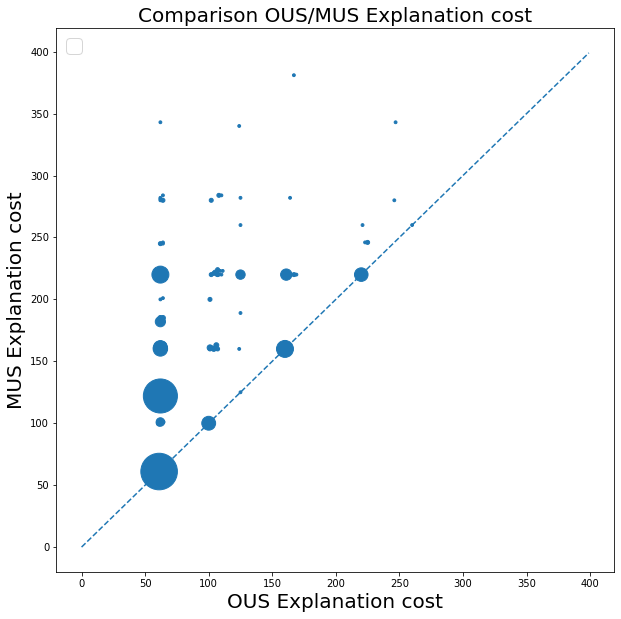

In [86]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment5_qualitative/2021011617/'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
mus_json_files = [f for f in json_files if 'MUS-time' in f['results'].keys()]
ous_json_files = [f for f in json_files if f not in mus_json_files]
musCosts = extractCosts(mus_json_files)
ousCosts = extractCosts(ous_json_files)

plotCosts(ousCosts, musCosts)

# Experiment6

For every puzzle get the explanation sequence fastest result

folder = 

In [159]:
def musTimes(jsonMUS, instances):
    results = {k: 7200 for k in instances}
    for musTime in jsonMUS:
        results[musTime['config']['instance']] = sum(musTime['results']['MUS-time'])
    return results

In [160]:
def jsonToBest(jsonFiles, instances):
    results = {k: 7200 for k in instances}
    for f in jsonFiles:
        instance = f['config']['instance']
        totTime =  f["config"]["timeout"] if f['results']["timeout"] else sum(f['results']["OUS-time"]) 
        if instance not in results or totTime < results[instance] :
            results[instance] = totTime
    return results



In [178]:
def greedyJsonToBest(jsonFiles, instances):
    resultsIncr = {k: 7200 for k in instances}
    resultsNonIncr = {k: 7200 for k in instances}
    for f in jsonFiles:
        instance = f['config']['instance']
        totTime = f['results']['totTime'] if 'totTime' in f['results'] else sum(sum(subl) for subl in f['results']["OUS-time"])
        if f['config']['reuse_SSes']:
            if instance not in resultsIncr or totTime <= resultsIncr[instance]:
                resultsIncr[instance] = totTime
        else:
            if instance not in resultsNonIncr or totTime <= resultsNonIncr[instance]:
                resultsNonIncr[instance] = totTime

    return resultsIncr, resultsNonIncr

In [179]:
def fillDictResults(dictResults, results, Name):
    for k,v in results.items():
        pos = dictResults['puzzles'].index(k)
        dictResults[Name][pos] = round(v)

In [181]:
# MUS

musFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment5/2021011509'
instances = set(read_json(f)['config']['instance'] for f in list_json_dir(musFolder))
musFiles = [read_json(f) for f in list_json_dir(musFolder)]
musResults = musTimes(musFiles, instances)

# # cOUS
cOUSnonIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_cous/20210117'
cOUSNonIncrFiles = [read_json(f) for f in list_json_dir(cOUSnonIncrFolder)]
cOUSNonIncrResults = jsonToBest(cOUSNonIncrFiles, instances)

cOUSIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
cOUSIncrFiles = [read_json(f) for f in list_json_dir(cOUSIncrFolder)]
cOUSIncrResults = jsonToBest(cOUSIncrFiles, instances)

# # Greedy
greedyFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_greedy/20210117/'
greedyFiles = [read_json(f) for f in list_json_dir(greedyFolder)]
greedyIncrResults, greedyNonIncrResults = greedyJsonToBest(greedyFiles, instances)

# seperate in Incremental and non-incremental

dictResults = {
    'puzzles': [k for k in instances],
    'MUS-based': [0 for k in instances],
    'OUS non-incr': [0 for k in instances],
    'OUS incr': [0 for k in instances],
    'cOUS non-incr': [0 for  k in  instances],
    'cOUS + incr':[0 for k in instances]
}


fillDictResults(dictResults, musResults, 'MUS-based')
fillDictResults(dictResults, greedyNonIncrResults, 'OUS non-incr')
fillDictResults(dictResults, greedyIncrResults, 'OUS incr')
fillDictResults(dictResults, cOUSNonIncrResults, 'cOUS non-incr')
fillDictResults(dictResults, cOUSIncrResults, 'cOUS + incr')

dfExp6 = pd.DataFrame(dictResults)
print(dfExp6)

          puzzles  MUS-based  OUS non-incr  OUS incr  cOUS non-incr  \
0             p25       2351          7200      7200            645   
1             p13       4016          7200      7200           2308   
2             p18       3575          7200      5054            314   
3             p93       3401          7200      7200            644   
4     pastaPuzzle        541          7200      3617            618   
5  origin-problem       2980          7200      7051            779   
6             p20       3208          7200      7200            371   
7             p12       2601          7200      7200            874   
8             p16       3047          7200      5731            565   

   cOUS + incr  
0          414  
1         1135  
2           97  
3          448  
4          528  
5          299  
6          146  
7          607  
8          238  
